In [1]:
import os
import numpy as np
import json
from wsrlib import pyart, radar2mat
from wsrlib import read_http
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from matplotlib import image

NORMALIZERS = {
        'reflectivity':              pltc.Normalize(vmin=  -5, vmax= 35),
        'velocity':                  pltc.Normalize(vmin= -15, vmax= 15),
        'spectrum_width':            pltc.Normalize(vmin=   0, vmax= 10),
        'differential_reflectivity': pltc.Normalize(vmin=  -4, vmax= 8),
        'differential_phase':        pltc.Normalize(vmin=   0, vmax= 250),
        'cross_correlation_ratio':   pltc.Normalize(vmin=   0, vmax= 1.1)
}


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Assume we have a json file that contains annotations.
# Load the scan list and annotations from json.
JSON_PATH = "../datasets/roosts_v0.0.1_official/roosts_v0.0.1.json"
with open(JSON_PATH, "r") as f:
    dataset = json.load(f)
    attributes = dataset["info"]["array_fields"]
    elevations = dataset["info"]["array_elevations"]

# Let's visualize three classic radar products at five elevations
# Roosts are typically visible only at low elevantions
ATTRIBUTES = ["reflectivity", "velocity", "spectrum_width"]
ELEVATIONS = [0.5, 1.5, 2.5, 3.5, 4.5]

/scratch2/wenlongzhao/anaconda3/envs/roostsys/lib/python3.6/site-packages/pyart/io/nexrad_archive.py:212: UserWarning: Gate spacing is not constant, interpolating data in scans [4, 5, 6, 7, 8, 9, 10] for moment REF.
  UserWarning)


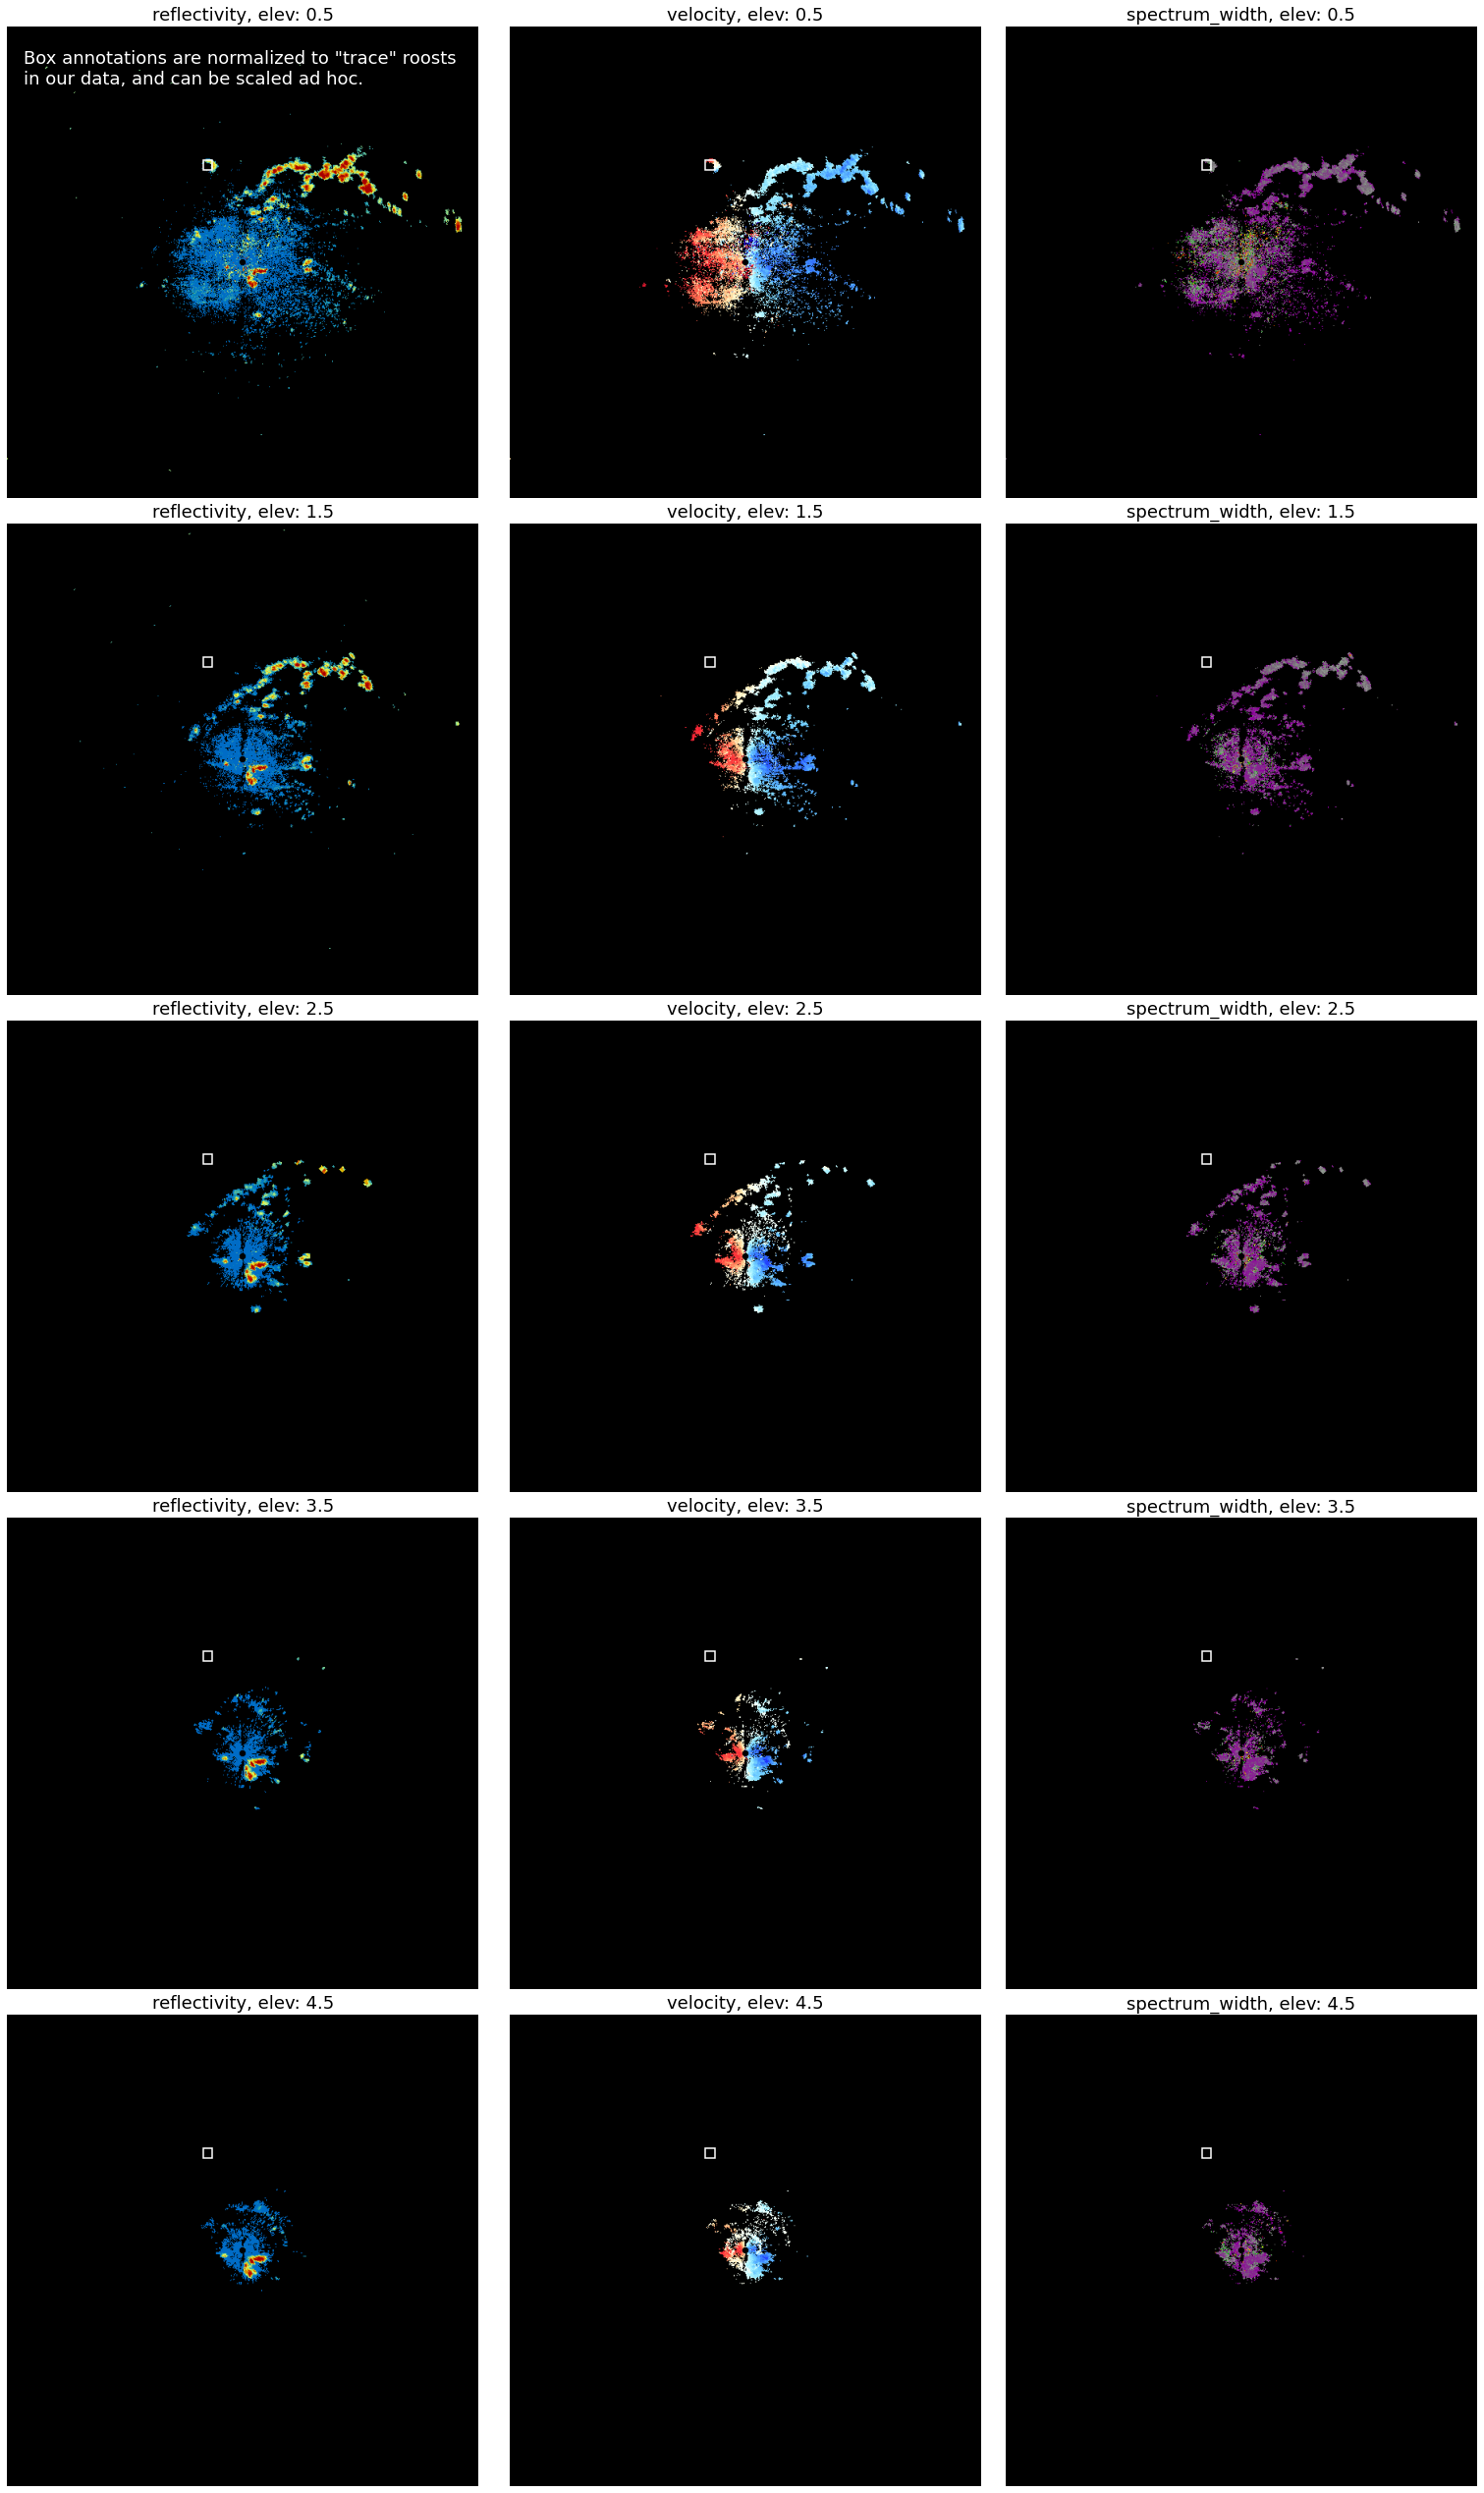

In [3]:
# Find the first scan that has an annotation in the json
i = 0
while not dataset["scans"][i]["annotation_ids"]:
    i += 1
scan = dataset["scans"][i]

# Case 1. We render an array on the fly
radar = read_http(scan["key"])
array, fields, elevs, y, x = radar2mat(
    radar,
    ydirection="xy", # geographic direction, y is first dim (row), large y is North, row 0 is South
    fields=ATTRIBUTES,
    coords='cartesian',
    r_max=150000,
    dim=600,
    elevs=ELEVATIONS
)
# Case 2. We already have rendered radar arrays on the disk.
# array = np.load(os.path.join(dataset["info"]["array_dir"], scan["array_path"]))["array"]

# Set up the plot grid
fig, axs = plt.subplots(
    len(ELEVATIONS), len(ATTRIBUTES), 
    figsize=(7*len(ATTRIBUTES), 7*len(ELEVATIONS)), 
    constrained_layout=True
)

# Plot
for i, attr in enumerate(ATTRIBUTES):
    for j, elev in enumerate(ELEVATIONS):
        if len(ATTRIBUTES) > 1 and len(ELEVATIONS) > 1:
            subplt = axs[j, i]
        elif len(ATTRIBUTES) > 1:
            subplt = axs[i]
        else:
            subplt = axs[j]
        subplt.axis('off')
        subplt.set_title(f"{attr}, elev: {elev}", fontsize=18)
        cm = plt.get_cmap(pyart.config.get_field_colormap(attr))
        rgb = cm(NORMALIZERS[attr](
            array[attributes.index(attr), elevations.index(elev), :, :]
        ))[:, :, :3] # omit the fourth alpha dimension
        # save the channel as png image in the image direction (row 0 is North, large y is South)
        # image.imsave(os.path.join(OUTPUT_DIR, f"{scan['key']}_{attr}{elev}.png"), rgb[::-1, :, :])
        subplt.imshow(
            rgb, origin='lower'
        ) # set the origin to lower so that north is the top of the image
        
        # draw bounding box
        for annotation_id in scan["annotation_ids"]:
            bbox = dataset["annotations"][annotation_id]["bbox"]
            subplt.add_patch(
                patches.Rectangle(
                    (bbox[0], bbox[1]), bbox[2], bbox[3], # xy, w, h
                    linewidth=1.5, edgecolor='white', facecolor='none'
                )
            )
            if i == j == 0:
                subplt.text(
                    20, 500, 
                    'Box annotations are normalized to \"trace\" roosts \n' \
                    'in our data, and can be scaled ad hoc.\n',
                    bbox=dict(facecolor='white', alpha=0), fontsize=18, color='white'
                )
plt.show()
plt.close(fig)

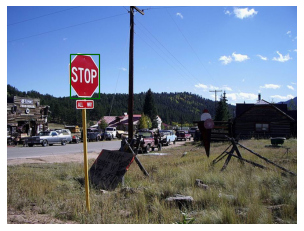

In [4]:
# Visualize a random image with annotations from coco-2017 val data
# to confirm that we are using the same bbox format as coco

# define which scan to visualize, which json to be the source of annotations
IMAGE = "tmp/000000222094.jpg"
BBOX = [107.87, 81.74, 49.71, 75.0]

rgb = plt.imread(IMAGE)
fig, axs = plt.subplots()
axs.axis('off')
axs.imshow(rgb) # set the origin to lower so that north is the top of the image
axs.add_patch(
    plt.Rectangle(
        (BBOX[0], BBOX[1]), BBOX[2], BBOX[3], 
        fill=False, edgecolor='#006400', linewidth=1.2
    )
)

plt.show()
plt.close(fig)